###  01 Exploratory Data Analysis

# 🧭 Main EDA — Global Overview of All CSVs

**Goal:** This notebook performs a **global EDA** across all CSV datasets (events, careplan, obs, qresp, support, etc.)  
to understand their **structure**, **quality**, and **relationships**.

It acts as the **master notebook**, serving as the foundation for the upcoming **per-table EDA notebooks**.

**What this notebook does:**
1. Automatically loads all CSVs  
2. Displays structure (rows, columns, data types)  
3. Detects and parses all date/time fields  
4. Cleans the data (column names, empty columns, duplicates)  
5. Provides descriptive statistics and top categories  
6. Checks **relationships between tables** (key coverage)  
7. Exports cleaned CSVs for downstream use

In [ ]:
# === Imports & Settings ==
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 400)


# 1. Automatically loads all CSVs 

In [3]:

# Paths
RAW = Path("../../data/Raw") # ../ comeback to notebooks -> ../ come to SeroProjectCode -> ../ come to data -> Raw

# Load CSVs
careplan = pd.read_csv(RAW / "SERO-careplan.csv", low_memory=False,sep=";")
events = pd.read_csv(RAW / "SERO-events.csv", low_memory=False)
obs = pd.read_csv(RAW / "SERO-Observations.csv", low_memory=False,sep=";")
qresp = pd.read_csv(RAW / "SERO-QuestionnaireResponses.csv", low_memory=False,sep=";")
support = pd.read_csv(RAW / "SERO-SupportCareplan.csv", low_memory=False,sep=";")


In [4]:
#dictionnries creation
tables = {
    "careplan": careplan,
    "events": events,
    "obs": obs,
    "qresp": qresp,
    "support": support
}

for name, df in tables.items():
    print(name, df.shape)

careplan (11398, 8)
events (65803, 13)
obs (1976, 11)
qresp (6108, 8)
support (1727, 8)


# 2.Displays structure (rows, columns, data types)

In [5]:
# Standardize column names
for df in [careplan, events, obs, qresp, support]:
    df.columns = df.columns.str.strip().str.lower() #str.strip() enlève les espaces en début/fin de chaque nom, puis str.lower() met tout en minuscules

# Summary “at a glance” table (rows, cols, memory, missing %, duplicates, sample columns)
import numpy as np

def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1e6, 2) #memory in MB 

summary_rows = []
for name, df in tables.items():
    summary_rows.append({
        "TABLE": name.upper(),
        "ROWS": len(df),
        "COLS": df.shape[1],
        "MEM_MB": mem_mb(df),
        "MISSING_%(avg)": round(df.isna().mean().mean() * 100, 2) if len(df) else 0.0,
        "DUPLICATES": int(df.duplicated().sum()),
        "DTYPES_SAMPLE": ", ".join(df.dtypes.astype(str).value_counts().head(3).index.tolist()),
        "COLUMNS_SAMPLE": ", ".join(map(str, df.columns[:8])) + (" ..." if df.shape[1] > 8 else "")
    })

summary = pd.DataFrame(summary_rows).sort_values("TABLE").reset_index(drop=True)

# Style: highlight higher missingness, right-align numbers, borders
summary_style = (
    summary
    .style
    .hide(axis="index")
    .set_properties(subset=["ROWS","COLS","MEM_MB","MISSING_%(avg)","DUPLICATES"], **{"text-align": "right"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left"), ("font-weight", "600")]},
        {"selector": "td, th", "props": [("border", "1px solid #ddd"), ("padding", "6px 10px")]},
        {"selector": "table", "props": [("border-collapse", "collapse")]}
    ])
    .background_gradient(subset=["MISSING_%(avg)"], cmap="Reds")
    .format({"MEM_MB": "{:.2f}", "MISSING_%(avg)": "{:.2f}"})
)
summary_style

TABLE,ROWS,COLS,MEM_MB,MISSING_%(avg),DUPLICATES,DTYPES_SAMPLE,COLUMNS_SAMPLE
CAREPLAN,11398,8,6.10,0.00,4,object,"id, subject, status, datetime, date, time, topic, description"
EVENTS,65803,13,36.92,16.51,225,"object, int64, float64","idsite, iduser, idvisitor, idvisit, visit_starttime, visit_endtime, event_time, id_event_name ..."
OBS,1976,11,1.02,0.77,0,"object, float64","id, subject, datetime, date, time, distance, distanceunit, xcoordinate ..."
QRESP,6108,8,3.10,0.00,0,"object, float64","id, subject, datetime, date, time, partof, linkid, answer"
SUPPORT,1727,8,0.89,0.00,3,object,"id, subject, status, datetime, date, time, topic, description"


We can see that there is 16% of missing value in Events table and a bit also in Obs table, so we want to check what type of column have missing value

## Missing Value check 

Tables with missing values: ['events', 'obs']


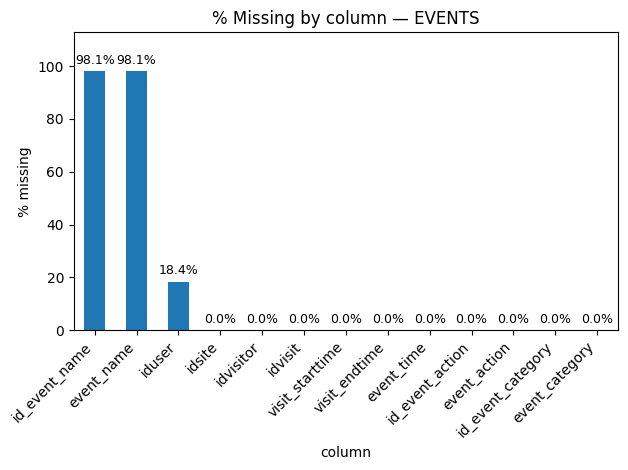

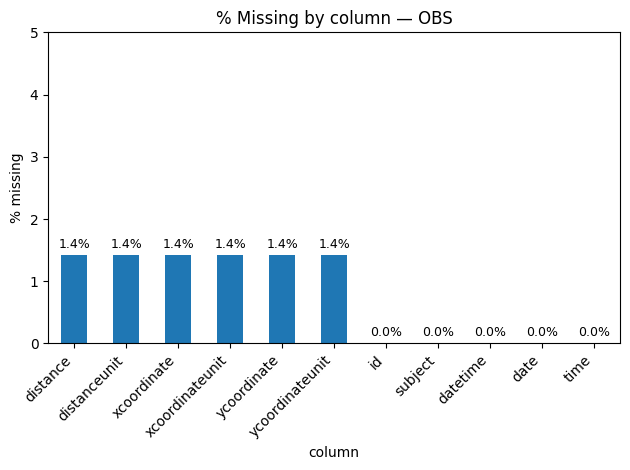

In [6]:
# Keep only the tables that actually have at least one missing value
df_missing = {name: df for name, df in tables.items() if df.isna().any().any()}

# Quick check
print("Tables with missing values:", list(df_missing.keys()))

# Plot missingness with % labels on each bar
for name, df in df_missing.items():
    miss = df.isna().mean().mul(100).sort_values(ascending=False)
    if miss.empty:
        continue

    fig, ax = plt.subplots()
    ax = miss.plot(kind="bar", ax=ax)

    # Title & axes
    ax.set_title(f"% Missing by column — {name.upper()}")
    ax.set_ylabel("% missing")
    ax.set_xlabel("column")

    # Rotate x labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Add exact % labels above each bar
    for patch, (_, val) in zip(ax.patches, miss.items()):
        ax.annotate(
            f"{val:.1f}%",
            (patch.get_x() + patch.get_width() / 2, patch.get_height()),
            ha="center", va="bottom",
            xytext=(0, 3), textcoords="offset points",
            fontsize=9
        )

    # Nice top padding
    ax.set_ylim(0, max(miss.max() * 1.15, 5))

    plt.tight_layout()
    plt.show()

For **EVENTS** is a lot of data missing in the id_event_name and event_name, the pourcentage are the same, we can think that those two are completly correlated during creation, it seems that iduser are also missing close to 20% of the value 

For **OBS** it seems that :

 - distance
 - distanceunit
 - xcoordinate
 - xcoordinateunit
 - ycoordinate
 - ycoordinateunit

 
Are missing, it seems like it's all related to the distance to "suicide idea" function --> maybe people that forgot to answer ? 



## Check of the table forms 

In [12]:
from IPython.display import display, HTML

for name, df in tables.items():
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:10px 14px;">
        <div style="font-weight:700;font-size:16px;margin-bottom:6px;">
            {name.upper()}
        </div>
        <div>{df.head(5).to_html(index=False)}</div>
    </div>
    """))
 

id,subject,status,datetime,date,time,topic,description
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,motivation,Freundeskreis
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,warningSigns,"trauer, angst"
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,Kochen
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,wandern
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,singen


idsite,iduser,idvisitor,idvisit,visit_starttime,visit_endtime,event_time,id_event_name,event_name,id_event_action,event_action,id_event_category,event_category
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:03:51+00:00,NaN,NaN,603,view_current,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:23+00:00,NaN,NaN,635,view_tutorial,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:35+00:00,NaN,NaN,603,view_current,578,securityPlan
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:03+00:00,NaN,NaN,624,call_proJuventute,566,contacts
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:07+00:00,NaN,NaN,615,call_dieDargeboteneHand,566,contacts


id,subject,datetime,date,time,distance,distanceunit,xcoordinate,xcoordinateunit,ycoordinate,ycoordinateunit
P281d973a48dc96616df59380f31b5921ec43bd46,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,3.2,cm,21.5,cm,13.2,cm
P2effc9a24a8b816cfcdd2b9f3b846913c5e15b4e,P-87EG-KFEL,2024-11-05 15:57:11.766000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:57:11+00:00,NaN,NaN,NaN,NaN,NaN,NaN
Pbddaaa06ec21bb7fa59602b157bda257720de6d7,P-87EG-KFEL,2024-11-05 19:05:03.403000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 19:05:03+00:00,9.0,cm,14.9,cm,16.0,cm
Pe60ba3aca2bcff5958b646dac4f80afb7fce945c,P-87EG-KFEL,2024-11-05 19:05:53.259000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 19:05:53+00:00,9.2,cm,14.9,cm,13.5,cm
P77a46c74e00d502303e23ffc0378fd465d45d1ad,P-87EG-KFEL,2024-11-07 08:38:24.591000+00:00,2024-11-07 00:00:00+00:00,2025-10-13 08:38:24+00:00,7.2,cm,25.6,cm,8.3,cm


id,subject,datetime,date,time,partof,linkid,answer
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,1.1,Grosse Verunsicherung
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,2.1,Suizid
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,3.1,Wärme im Bauch
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,4.1,Angst
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,5.1,das app


id,subject,status,datetime,date,time,topic,description
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Dokumentationen
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Geschichte
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Prozesse
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,creativity,"Kochen, neue Rezepte"
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,creativity,Gärtnern



# 3. Detects and parses all date/time fields  
 #### Fonctions 
 

In [8]:
# === Cleaning utilities ===

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Lowercase, strip spaces, replace spaces/dashes with underscores,
    and remove special characters.
    """
    new_cols = []
    for c in df.columns:
        c2 = str(c).strip().lower()
        c2 = re.sub(r"[\s\-/]+", "_", c2)
        c2 = re.sub(r"[^0-9a-zA-Z_]", "", c2)
        new_cols.append(c2)
    df.columns = new_cols
    return df


# ------------------------------------------------------------------------------------------------------

DATE_TOKENS = ("date", "time", "datetime", "timestamp", "period", "start", "end")
    
def find_date_columns(df: pd.DataFrame):
    """
    Return a sorted list of column names in `df` whose *name* contains
    any of the substrings in `DATE_TOKENS` (case-insensitive).

    Notes:
    - Operates on the provided DataFrame only.
    - Matches on column *names* (not values or dtypes).
    - Returns unique, sorted column names.
    """
    cols = []
    for c in df.columns:
        lc = c.lower()
        if any(tok in lc for tok in DATE_TOKENS):
            cols.append(c)
    return sorted(set(cols))


# ------------------------------------------------------------------------------------------------

def parse_dates_inplace(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Converts given columns to datetime (UTC), coercing errors.
    Returns a small report showing changes in NA counts.
    """
    report = []
    for c in cols:
        na_before = df[c].isna().sum() if c in df.columns else None
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True, infer_datetime_format=True)
            na_after = df[c].isna().sum()
            report.append((c, na_before, na_after, str(df[c].dtype)))
        except Exception as e:
            report.append((c, na_before, None, f"FAILED: {e}"))
    rep_df = pd.DataFrame(report, columns=["column", "na_before", "na_after", "dtype/notes"])
    return rep_df

# ------------------------------------------------------------------------------------------------

def drop_empty_columns(df: pd.DataFrame) -> list:
    """Drops columns that are entirely empty (NaN) and returns their names."""
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df.drop(columns=empty_cols, inplace=True)
    return empty_cols

# ------------------------------------------------------------------------------------------------

def profile_dataframe(df: pd.DataFrame, sample_cats: int = 8) -> dict:
    """
    Lightweight profiling summary (shape, dtypes, %missing, duplicates, nunique, top categories).
    """
    d = {
        "shape": df.shape,
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing_perc": (df.isna().mean().round(4) * 100).to_dict(),
        "duplicates": int(df.duplicated().sum()),
        "nunique": {c: int(df[c].nunique(dropna=True)) for c in df.columns[:1000]}
    }
    tops = {}
    for c in df.select_dtypes(include="object").columns[:100]:
        vc = df[c].value_counts(dropna=True)
        tops[c] = vc.head(sample_cats).to_dict()
    d["top_categories"] = tops
    return d

In [ ]:
# Optional: silence pandas' generic date parsing warnings
SILENCE_PARSE_WARNINGS = True
if SILENCE_PARSE_WARNINGS:
    warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Optional: explicit formats if you know them (faster, no ambiguity)
FORMAT_MAP = {
    # "date": "%Y-%m-%d",
    # "datetime": "%Y-%m-%d %H:%M:%S",
    # "time": "%H:%M:%S",
}
DEFAULT_DAYFIRST = False



# === Apply cleaning & date parsing per table ===
clean_reports = {}
empty_cols_dropped = {}

for name, df in tables.items():
    tables[name] = standardize_columns(df)
    df = tables[name]
    removed = drop_empty_columns(df)
    if removed:
        empty_cols_dropped[name] = removed
    date_cols = find_date_columns(df)
    rep = parse_dates_inplace(df, date_cols)
    clean_reports[name] = {
        "date_columns_detected": date_cols,
        "date_parse_report": rep
    }

print("Dropped 100% empty columns (by table):")
print(empty_cols_dropped if empty_cols_dropped else "None")

# Example report
for name, rep in clean_reports.items():
    print(f"\n=== {name} — date parse report ===")
    display(rep)

Dropped 100% empty columns (by table):
None

=== careplan — date parse report ===


/var/folders/7_/2b5rmfrx06qbfxm4wk39j58r0000gn/T/ipykernel_18219/1499094210.py:51: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", utc=True, infer_datetime_format=True)
/var/folders/7_/2b5rmfrx06qbfxm4wk39j58r0000gn/T/ipykernel_18219/1499094210.py:51: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", utc=True, infer_datetime_format=True)
/var/folders/7_/2b5rmfrx06qbfxm4wk39j58r0000gn/T/ipykernel_18219/1499094210.py:51: UserWarning: The argument 'infer_datetime_format' i

{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== events — date parse report ===


{'date_columns_detected': ['event_time', 'visit_endtime', 'visit_starttime'],
 'date_parse_report':             column  na_before  na_after          dtype/notes
 0       event_time          0         0  datetime64[ns, UTC]
 1    visit_endtime          0         0  datetime64[ns, UTC]
 2  visit_starttime          0         0  datetime64[ns, UTC]}


=== obs — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== qresp — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== support — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}

### Check after parsing 

In [21]:
from IPython.display import display, HTML

def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1e6, 2) #memory in MB 

summary_rows = []
for name, df in tables.items():
    summary_rows.append({
        "TABLE": name.upper(),
        "ROWS": len(df),
        "COLS": df.shape[1],
        "DTYPES_SAMPLE": ", ".join(df.dtypes.astype(str).value_counts().head(3).index.tolist()),
        "COLUMNS_SAMPLE": ", ".join(map(str, df.columns[:8])) + (" ..." if df.shape[1] > 8 else "")
    })

summary = pd.DataFrame(summary_rows).sort_values("TABLE").reset_index(drop=True)

# Style: highlight higher missingness, right-align numbers, borders
summary_style = (
    summary
    .style
    .hide(axis="index")
    .set_properties(subset=["ROWS","COLS"], **{"text-align": "right"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left"), ("font-weight", "600")]},
        {"selector": "td, th", "props": [("border", "1px solid #ddd"), ("padding", "6px 10px")]},
        {"selector": "table", "props": [("border-collapse", "collapse")]}
    ])
)
summary_style

display(summary_style)

for name, df in tables.items():
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:10px 14px;">
        <div style="font-weight:700;font-size:16px;margin-bottom:6px;">
            {name.upper()}
        </div>
        <div>{df.head(5).to_html(index=False)}</div>
    </div>
    """))

TABLE,ROWS,COLS,DTYPES_SAMPLE,COLUMNS_SAMPLE
CAREPLAN,11398,8,"object, datetime64[ns, UTC]","id, subject, status, datetime, date, time, topic, description"
EVENTS,65803,13,"object, int64, datetime64[ns, UTC]","idsite, iduser, idvisitor, idvisit, visit_starttime, visit_endtime, event_time, id_event_name ..."
OBS,1976,11,"object, datetime64[ns, UTC], float64","id, subject, datetime, date, time, distance, distanceunit, xcoordinate ..."
QRESP,6108,8,"object, datetime64[ns, UTC], float64","id, subject, datetime, date, time, partof, linkid, answer"
SUPPORT,1727,8,"object, datetime64[ns, UTC]","id, subject, status, datetime, date, time, topic, description"


id,subject,status,datetime,date,time,topic,description
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,motivation,Freundeskreis
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,warningSigns,"trauer, angst"
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,Kochen
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,wandern
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:44:36+00:00,copingStrategies,singen


idsite,iduser,idvisitor,idvisit,visit_starttime,visit_endtime,event_time,id_event_name,event_name,id_event_action,event_action,id_event_category,event_category
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:03:51+00:00,NaN,NaN,603,view_current,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:23+00:00,NaN,NaN,635,view_tutorial,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:35+00:00,NaN,NaN,603,view_current,578,securityPlan
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:03+00:00,NaN,NaN,624,call_proJuventute,566,contacts
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:07+00:00,NaN,NaN,615,call_dieDargeboteneHand,566,contacts


id,subject,datetime,date,time,distance,distanceunit,xcoordinate,xcoordinateunit,ycoordinate,ycoordinateunit
P281d973a48dc96616df59380f31b5921ec43bd46,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,3.2,cm,21.5,cm,13.2,cm
P2effc9a24a8b816cfcdd2b9f3b846913c5e15b4e,P-87EG-KFEL,2024-11-05 15:57:11.766000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:57:11+00:00,NaN,NaN,NaN,NaN,NaN,NaN
Pbddaaa06ec21bb7fa59602b157bda257720de6d7,P-87EG-KFEL,2024-11-05 19:05:03.403000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 19:05:03+00:00,9.0,cm,14.9,cm,16.0,cm
Pe60ba3aca2bcff5958b646dac4f80afb7fce945c,P-87EG-KFEL,2024-11-05 19:05:53.259000+00:00,2024-11-05 00:00:00+00:00,2025-10-13 19:05:53+00:00,9.2,cm,14.9,cm,13.5,cm
P77a46c74e00d502303e23ffc0378fd465d45d1ad,P-87EG-KFEL,2024-11-07 08:38:24.591000+00:00,2024-11-07 00:00:00+00:00,2025-10-13 08:38:24+00:00,7.2,cm,25.6,cm,8.3,cm


id,subject,datetime,date,time,partof,linkid,answer
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,1.1,Grosse Verunsicherung
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,2.1,Suizid
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,3.1,Wärme im Bauch
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,4.1,Angst
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-10-13 15:47:12+00:00,672a3e00bd2fa86b213da4a1,5.1,das app


id,subject,status,datetime,date,time,topic,description
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Dokumentationen
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Geschichte
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,newLearning,Prozesse
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,creativity,"Kochen, neue Rezepte"
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-10-13 11:33:12+00:00,creativity,Gärtnern


event_category,COUNT,PCT
securityPlan,19710,29.95
roleChoice,15727,23.90
assessment,10096,15.34
contacts,6360,9.67
settings,4304,6.54
resourcePlan,2308,3.51
sharedSecurityPlan,2223,3.38
treasureChest,1775,2.70
information,1685,2.56
sharingSecurityPlan,1615,2.45


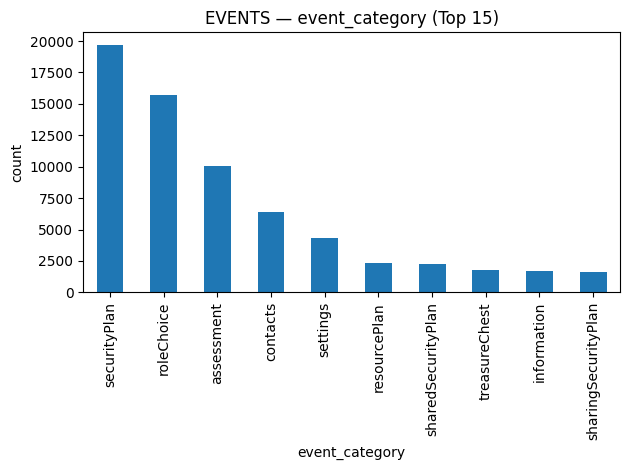

status,COUNT,PCT
active,11025,96.73
revoked,373,3.27


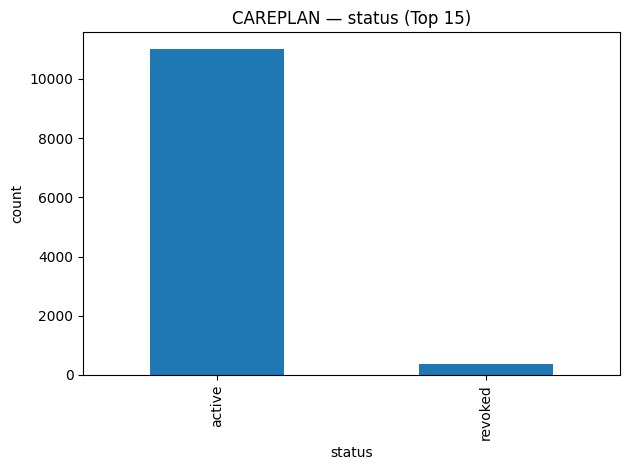

,VALUE
count,1948.000
mean,13.918
std,7.753
min,0.000
25%,7.400
50%,13.100
75%,21.700
max,24.900
q00,0.000
q01,0.200


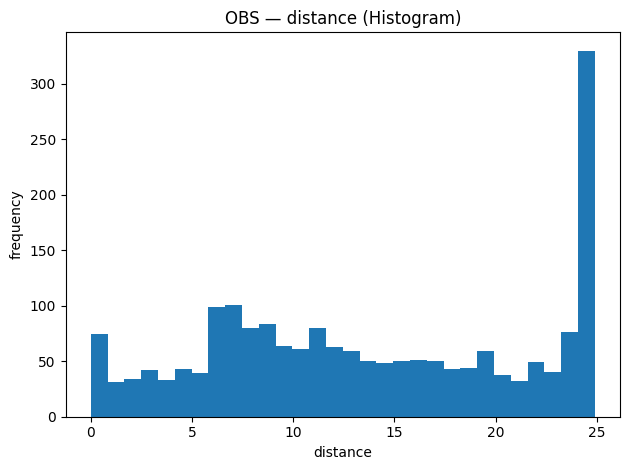

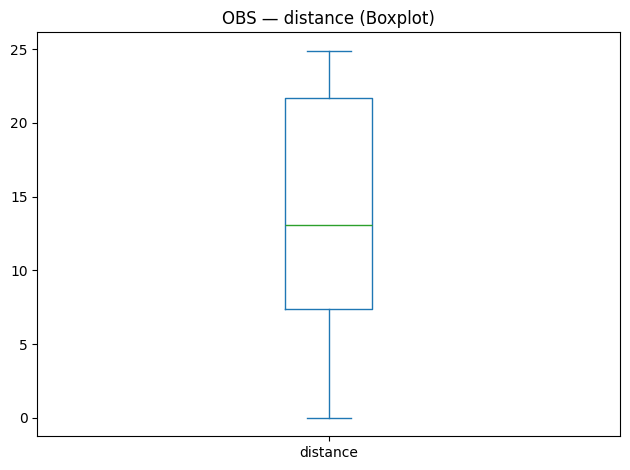

In [15]:
# ==== Pretty Descriptive Stats (Tables + Small Charts) ====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def cat_summary(df: pd.DataFrame, col: str, top: int = 20) -> pd.DataFrame:
    """Return a tidy count + percent table for a categorical column."""
    if col not in df.columns:
        return pd.DataFrame({"note": [f"Column '{col}' not found"]})
    vc = df[col].value_counts(dropna=False)
    out = (vc
           .rename("COUNT")
           .to_frame()
           .assign(PCT=lambda x: (x["COUNT"] / x["COUNT"].sum() * 100).round(2))
           .reset_index()
           .rename(columns={"index": col}))
    return out.head(top)

def card(title_html: str, inner_html: str) -> None:
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:12px 14px;">
      <div style="font-weight:700;font-size:16px;margin-bottom:8px;">{title_html}</div>
      <div>{inner_html}</div>
    </div>
    """))

# --- EVENTS: event_category ---
events_cat_tbl = cat_summary(events, "event_category", top=20)

card(
    "EVENTS — EVENT_CATEGORY (Top 20)",
    events_cat_tbl.to_html(index=False)
)

# Optional: quick bar chart (top 15)
if "event_category" in events.columns and not events["event_category"].empty:
    top_counts = events["event_category"].value_counts(dropna=False).head(15)
    plt.figure()
    top_counts.plot(kind="bar")
    plt.title("EVENTS — event_category (Top 15)")
    plt.ylabel("count")
    plt.xlabel("event_category")
    plt.tight_layout()
    plt.show()

# --- CAREPLAN: status ---
careplan_status_tbl = cat_summary(careplan, "status", top=20)

card(
    "CAREPLAN — STATUS (Top 20)",
    careplan_status_tbl.to_html(index=False)
)

# Optional: quick bar chart (top)
if "status" in careplan.columns and not careplan["status"].empty:
    top_counts = careplan["status"].value_counts(dropna=False).head(15)
    plt.figure()
    top_counts.plot(kind="bar")
    plt.title("CAREPLAN — status (Top 15)")
    plt.ylabel("count")
    plt.xlabel("status")
    plt.tight_layout()
    plt.show()

# --- OBSERVATIONS: distance ---
if "distance" in obs.columns:
    # Numeric summary with extra quantiles
    q = obs["distance"].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.00]).round(3)
    dist_desc = obs["distance"].describe().round(3).to_frame("VALUE")
    dist_q = q.to_frame("VALUE")
    dist_q.index = dist_q.index.map(lambda x: f"q{int(x*100):02d}")

    card(
        "OBS — DISTANCE (Summary)",
        pd.concat([dist_desc, dist_q]).to_html()
    )

    # Histogram (distribution)
    plt.figure()
    obs["distance"].dropna().plot(kind="hist", bins=30)
    plt.title("OBS — distance (Histogram)")
    plt.xlabel("distance")
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()

    # Boxplot (outliers glance)
    plt.figure()
    obs["distance"].dropna().plot(kind="box")
    plt.title("OBS — distance (Boxplot)")
    plt.tight_layout()
    plt.show()
else:
    card("OBS — DISTANCE", "<i>Column 'distance' not found</i>")


## Relationship checks ( common columns and key coverae)

In [11]:
# === Relationship checks ===
from collections import defaultdict

col_presence = defaultdict(list)
for name, df in tables.items():
    for c in df.columns:
        col_presence[c].append(name)

common_cols = [c for c, tbls in col_presence.items() if len(tbls) >= 2]
print("Columns common to ≥2 tables (first 40):")
display(common_cols[:40])

def fk_coverage(df_src: pd.DataFrame, df_tgt: pd.DataFrame, key: str) -> float:
    """
    % of unique keys in df_src[key] also found in df_tgt[key].
    """
    if key not in df_src.columns or key not in df_tgt.columns:
        return np.nan
    s = pd.Series(df_src[key]).dropna().unique()
    t = set(pd.Series(df_tgt[key]).dropna().unique())
    if len(s) == 0:
        return np.nan
    return round(100 * sum(x in t for x in s) / len(s), 2)

CAND_KEYS = ["patient", "encounter", "id", "subject", "episode", "careplan", "obs", "questionnaire", "support"]
keys_to_try = sorted(set(CAND_KEYS + common_cols))

rel_rows = []
holders_by_key = {k: [name for name, df in tables.items() if k in df.columns] for k in keys_to_try}

for key, holders in holders_by_key.items():
    if len(holders) < 2:
        continue
    for a in holders:
        for b in holders:
            if a == b:
                continue
            cov = fk_coverage(tables[a], tables[b], key)
            rel_rows.append({"key": key, "from": a, "to": b, "coverage_%": cov})

rels = pd.DataFrame(rel_rows).sort_values(["key", "from", "to"]).reset_index(drop=True)
print("\n=== Potential key coverage (sample) ===")
display(rels.head(60))

Columns common to ≥2 tables (first 40):


['id', 'subject', 'status', 'datetime', 'date', 'time', 'topic', 'description']


=== Potential key coverage (sample) ===


,key,from,to,coverage_%
0,date,careplan,obs,90.29
1,date,careplan,qresp,80.19
2,date,careplan,support,16.89
3,date,obs,careplan,64.40
4,date,obs,qresp,87.12
...,...,...,...,...
55,time,obs,careplan,1.70
56,time,obs,qresp,66.32
57,time,obs,support,0.46
58,time,qresp,careplan,1.97
